### Deep Convolutional GAN

#### References
- [DCGAN in Keras](https://keras.io/examples/generative/dcgan_overriding_train_step/)
- [Advanced-Deep-Learning-with-Python/Chapter05](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Python/blob/master/Chapter05/dcgan.ipynb)

<a href="https://colab.research.google.com/github/paulaceccon/deep-learning-studies/blob/main/notebooks/generative_models/gans/dcgan.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Input,
    LeakyReLU,
    Reshape,
    Flatten
)
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Load the dataset

In [111]:
def preprocess(data: np.array) -> np.ndarray:
    data = (data.astype("float32")) / 255.0
    # data = (data.astype("float32")- 127.5) / 127.5  # this leads to divergence 
    data = np.reshape(data, (len(data), 28, 28, 1))
    return data

In [112]:
(x_train, _), _ = mnist.load_data()
x_train = preprocess(x_train)

print(x_train.shape)

(60000, 28, 28, 1)


### Visualization

In [113]:
def plot_generated_images(generator: Model, n_show: int = 10) -> None:
    # Display a 2D manifold of the digits
    n = 10
    digit_size = 28

    figure = np.zeros((digit_size * n_show, digit_size * n_show))
    latent_dim = generator.input_shape[1]

    # n*n random latent distributions
    noise = np.random.normal(0, 1, (n_show * n_show, latent_dim))
    generated_images = generator.predict(noise)

    for i in range(n):
        for j in range(n):
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")

### Model

In [114]:
def build_generator(latent_dim: int = 256) -> Model:
    """
    Produces 28x28 images.
    """
    generator_inputs = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 256)(generator_inputs)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(
        1, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="tanh"
    )(x)
    generator = Model(generator_inputs, x, name="generator")
    generator.summary()

    return generator

In [115]:
def build_discriminator() -> Model:
    """
    Classifies images as real or fake.
    """
    discriminator_inputs = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding="same")(
        discriminator_inputs
    )
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding="same")(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)
    discriminator = Model(discriminator_inputs, x)
    discriminator.summary()

    return discriminator

In [116]:
class GAN(Model):
    """Implements a variational autoencoder."""

    def __init__(self, generator: Model, discriminator: Model, latent_dim: int):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn) -> None:
        """
        Compile the model.

        Args:
            d_optimizer: discriminator's optimizer.
            g_optimizer: generator's optimizer.
            loss_fn: loss function.
        """
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self) -> list:
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images) -> dict:
        # 1. Train the discriminator
        # Sample random points in the latent space
        # and decode them to fake images
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        # and create lables
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 2. Train the generator
        # Sample random points in the latent space
        # and a ssemble labels that say "all real images"
        # (note that we should *not* update the weights of the discriminator)!
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # 3. Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### Training

In [117]:
def train_model(
    train_data: np.ndarray
) -> tuple:
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    latent_dim = 256
    discriminator = build_discriminator()
    generator = build_generator(latent_dim=latent_dim)
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=Adam(learning_rate=0.0001),
        g_optimizer=Adam(learning_rate=0.0001),
        loss_fn=BinaryCrossentropy(),
    )

    gan.fit(
        train_data,
        epochs=20,
        batch_size=128,
        verbose=1,
        callbacks=[tensorboard_callback],
    )
    return gan, discriminator, generator

In [118]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 127), started 1:45:09 ago. (Use '!kill 127' to kill it.)

<IPython.core.display.Javascript object>

In [119]:
_, _, generator = train_model(x_train)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 128)         0   

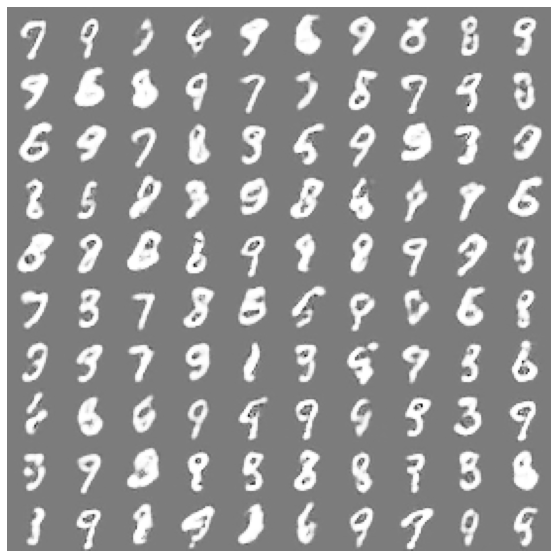

In [120]:
plot_generated_images(generator)